In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from wandb.apis.public.runs import Run

from flash_ansr import get_path

In [2]:
ids = {
    'v23.0-3M': 'vb932m41',
    'v23.0-20M': 'ufvsfmid',
    'v23.0-120M': '1r27w6hc',
    'v23.0-1B-1': '8je5usoa',
    'v23.0-1B-2': 'fq2dpksg',
    'v23.0-1B-3': 'pwbdnpko',
}

In [3]:
runs = {}
histories = {}
for version, run_id in ids.items():
    api = wandb.Api(timeout=120)
    run: Run = api.run(f'psaegert/neural-symbolic-regression/{run_id}')
    runs[version] = run
    histories[version] = [x for x in tqdm(run.scan_history(page_size=100000, keys=['total_pflops', 'total_gradient_norm', 'val_ce_loss', '_step']), total=run.summary['_step'] // 100000 + 1, desc=f'Fetching history for {version}')]

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from /home/psaegert/.netrc.


v23.0-1B-3:   0%|          | 26/4000000 [00:12<553:45:22,  2.01it/s] 


In [ ]:
data = {}
for version, history in histories.items():
    keys = history[0].keys()
    data[version] = {k: np.array([x[k] for x in history]).astype(float) for k in tqdm(keys, desc=version)}

v23.0-1B-3: 100%|██████████| 4/4 [00:00<00:00, 65536.00it/s]


In [68]:
data['v23.0-1B'] = {}

for key in ['_step'] + [k for k in data['v23.0-1B-1'].keys() if k != '_step']:
    data['v23.0-1B'][key] = data['v23.0-1B-1'][key]

step_copy = data['v23.0-1B']['_step'].copy()

for key in ['_step'] + [k for k in data['v23.0-1B-1'].keys() if k != '_step']:
    # Where there is data from the second part and from the first part, take the second part
    if key != 'total_pflops':
        data['v23.0-1B'][key] = np.concatenate([
            data['v23.0-1B'][key][step_copy < data['v23.0-1B-2']['_step'][0]],  # from first part (up to the start of the second part)
            data['v23.0-1B-2'][key]])
    else:
        # Add the last pflops from the first part to the second part to get a continuous pflops count
        data['v23.0-1B'][key] = np.concatenate([
            data['v23.0-1B'][key][step_copy < data['v23.0-1B-2']['_step'][0]],  # from first part (up to the start of the second part)
            data['v23.0-1B-2'][key] + data['v23.0-1B'][key][step_copy < data['v23.0-1B-2']['_step'][0]][-1]])
    
step_copy = data['v23.0-1B']['_step'].copy()

for key in ['_step'] + [k for k in data['v23.0-1B-1'].keys() if k != '_step']:
    if key != 'total_pflops':
        # Where there is data from the third part, take the third part, overwriting any overlapping steps from the first two parts
        data['v23.0-1B'][key] = np.concatenate([
            data['v23.0-1B'][key][step_copy < data['v23.0-1B-3']['_step'][0]],  # from first two parts (up to the start of the third part)
            data['v23.0-1B-3'][key]
        ])
    else:
        # Subtract the first pflops of the third part from the third part and add the last pflops of the first two parts to get a continuous pflops count
        data['v23.0-1B'][key] = np.concatenate([
            data['v23.0-1B'][key][step_copy < data['v23.0-1B-3']['_step'][0]],  # from first two parts (up to the start of the third part)
            data['v23.0-1B-3'][key] - data['v23.0-1B-3'][key][0] + data['v23.0-1B'][key][step_copy < data['v23.0-1B-3']['_step'][0]][-1]
        ])

In [69]:
clean_data = {key: data for key, data in data.items() if key != 'v23.0-1B-1' and key != 'v23.0-1B-2' and key != 'v23.0-1B-3'}

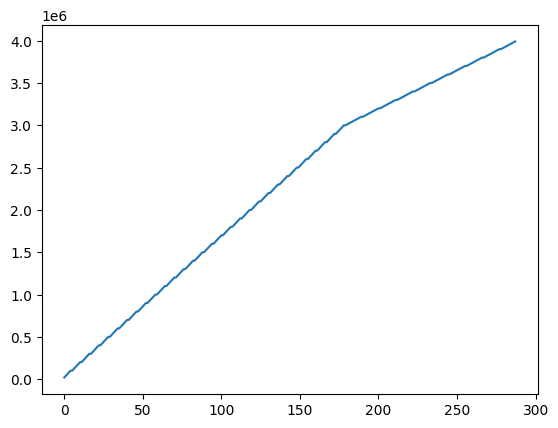

In [70]:
plt.plot(clean_data['v23.0-1B']['_step'])

In [71]:
def int_to_post(x):
    if x < 1000:
        return str(x)
    if x < 1e6:
        if x % 1000 == 0:
            return f'{int(x // 1000)}k'
        return f'{x // 1000:.1f}k'
    if x < 1e9:
        if x % 1e6 == 0:
            return f'{int(x // 1e6)}M'
        return f'{x / 1e6:.1f}M'

    if x % 1e9 == 0:
        return f'{int(x // 1e9)}B'
    return f'{x / 1e9:.1f}B'

In [72]:
colors = {
    'v23.0-3M': '#05C7F2',
    'v23.0-20M': '#05AFF2',
    'v23.0-120M': '#0468BF',
    'v23.0-1B': '#0339A6',
}

In [165]:
# Fit a "scaling law" curve to the final validation loss vs model size
last_losses = []
last_zflops = []
for version in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M', 'v23.0-1B']:
    last_loss = clean_data[version]['val_ce_loss'][-1]
    last_losses.append(last_loss)

    last_zflop = clean_data[version]['total_pflops'][-1] * 1e-6  # pflops to zettaflops
    last_zflops.append(last_zflop)

# Fit a power law: loss = a * (model_size)^b + c
from scipy.optimize import curve_fit
def power_law(x, a, b, c):
    return a * (x ** b) + c

popt, pcov = curve_fit(power_law, last_zflops, last_losses, p0=[1, -0.1, 0])
a, b, c = popt

In [166]:
print(f'Fitted power law parameters: a={a}, b={b}, c={c}')

Fitted power law parameters: a=0.4938589849313394, b=-0.13898537250653664, c=0.6227424188323314


In [167]:
last_zflops

[np.float64(0.0014009374128783354),
 np.float64(0.018733055583714492),
 np.float64(0.16836613877049297),
 np.float64(1.7268836138898775)]

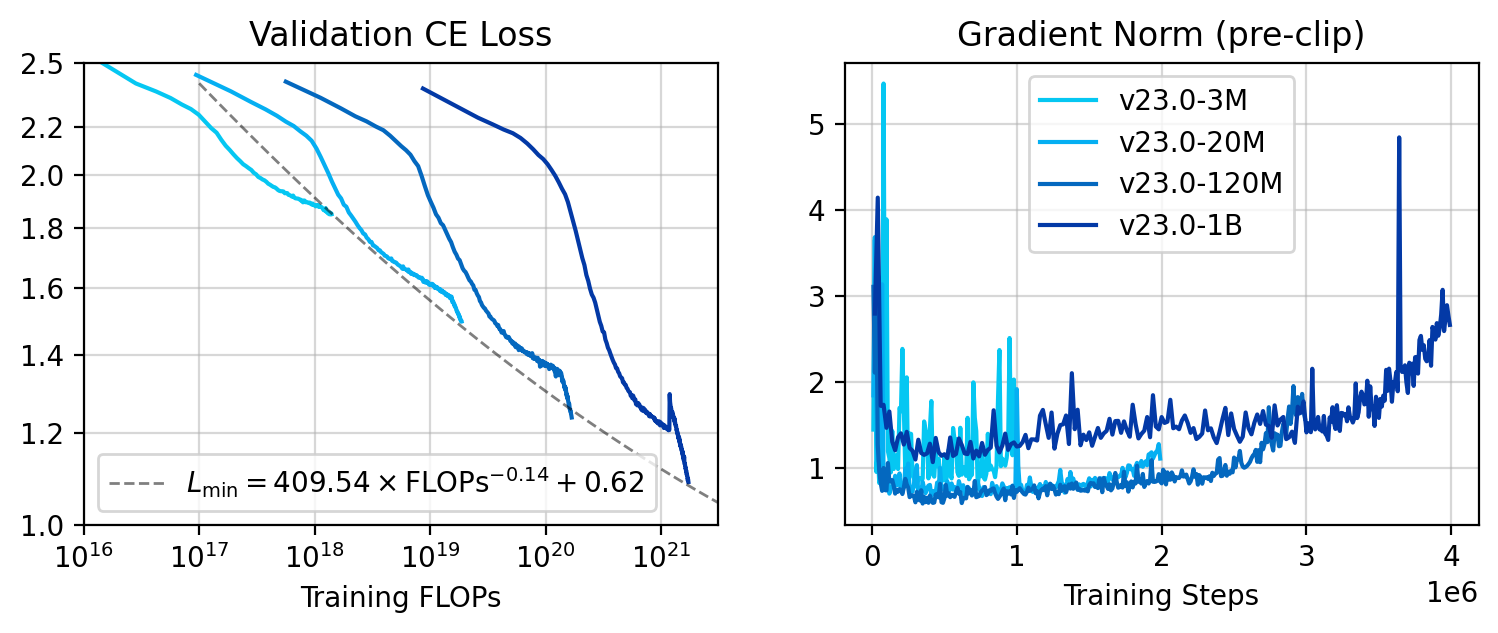

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=200)

for version, d in clean_data.items():
    steps = d['total_pflops'] * 1e15  # Convert from PFLOPs to FLOPs
    ce_loss = d['val_ce_loss']
    axes[0].plot(steps, ce_loss, color=colors[version])

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(10e15, None)

axes[0].set_ylim(1.0, 2.5)
axes[0].set_yticks([1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.5])
axes[0].set_yticklabels(['1.0', '1.2', '1.4', '1.6', '1.8', '2.0', '2.2', '2.5'])
axes[0].minorticks_off()

axes[0].grid(alpha=0.5)
axes[0].set_xlabel('Training FLOPs')
axes[0].set_title('Validation CE Loss')


x_vals = np.logspace(17, 22, 100)  # FLOPS
x_vals_zflops = x_vals * 1e-21  # Convert FLOPs to zettaflops
y_vals = power_law(x_vals_zflops, a, b, c)

# The power law is fitted in zetaflops space, so we need to convert the parameters accordingly
a_converted = a * (1e-21 ** b)
b_converted = b
c_converted = c

axes[0].plot(x_vals, y_vals, 'k', alpha=0.5, linestyle='--', linewidth=1, label=f'$L_\\mathrm{{min}}={a_converted:.2f} \\times \\mathrm{{FLOPs}}^{{{b_converted:.2f}}}+{c_converted:.2f}$')

axes[0].legend(loc='lower left')



for version, d in clean_data.items():
    steps = d['_step']
    grad_norm = d['total_gradient_norm']
    axes[1].plot(steps, grad_norm, label=version, color=colors[version])

axes[1].grid(alpha=0.5)
axes[1].set_xlabel('Training Steps')
axes[1].set_title('Gradient Norm (pre-clip)')

axes[1].legend()


plt.savefig(get_path('results', 'wandb', create=True, filename=f'training_curves.svg'), dpi=200)